In [1]:
import os
import re
import json
import yaml
import argparse
from test_metric import process_trial
from wbfm.utils.projects.finished_project_data import ProjectData
import matplotlib.pyplot as plt


def extract_val_loss(trial_path):
    stats_path = os.path.join(trial_path, "log", "stats.json")
    if not os.path.isfile(stats_path):
        print(f"No stats.json found at {stats_path}")
        return None

    try:
        with open(stats_path, "r") as f:
            stats = json.load(f)
        if len(stats) >= 2 and "val_loss" in stats[-2]:
            return stats[-2]["val_loss"]
        else:
            print(f"{stats_path} too short or missing 'val_loss'")
            return None
    except Exception as e:
        print(f"Error reading {stats_path}: {e}")
        return None


def discover_trials(trial_parent_dir):
    """
    Discovers trial numbers from folders named 'trial_<number>' in the given directory.
    """
    trials = []
    for entry in os.listdir(trial_parent_dir):
        entry_path = os.path.join(trial_parent_dir, entry)
        if os.path.isdir(entry_path) and entry.startswith("trial_"):
            match = re.match(r"trial_(\d+)", entry)
            if match:
                trials.append(int(match.group(1)))
    return sorted(trials)



def build_final_dict(gt_path, trial_dir, result_dir, trial_prefix):
    # Load GT once
    project_data_gt = ProjectData.load_final_project_data(gt_path)
    df_gt = project_data_gt.final_tracks

    result_dict = {
        "trial": [],
        "projector_final": [],
        "embedding_dim": [],
        "target_sz_z": [],
        "target_sz_xy": [],
        "p_RandomAffine_flip": [],
        "val_loss": [],
        "lr": [],
        "accuracy": [],
        "per_neuron_accuracy": [],
        "per_timepoint_accuracy": [],
        "misses_per_neuron_norm": [],
        "misses_per_timepoint_norm": [],
        "mismatches_per_neuron_norm": [],
        "mismatches_per_timepoint_norm": [],
    }


    trials = discover_trials(trial_dir)

    for trial_num in trials:
        trial_name = f"{trial_prefix}trial_{trial_num}"
        trial_name_config = f"trial_{trial_num}"
        trial_path = os.path.join(trial_dir, trial_name_config)
        result_path = os.path.join(result_dir, trial_name, "project_config.yaml")
        config_path = os.path.join(trial_path, "train_config.yaml")

        if not os.path.isfile(config_path):
            print(f"{trial_name}: train_config.yaml not found.")
            continue

        try:
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)

            result_dict["trial"].append(trial_num)
            result_dict["projector_final"].append(config.get("projector_final"))
            result_dict["embedding_dim"].append(config.get("embedding_dim"))
            result_dict["target_sz_z"].append(config.get("target_sz_z"))
            result_dict["target_sz_xy"].append(config.get("target_sz_xy"))
            result_dict["p_RandomAffine_flip"].append(config.get("p_RandomAffine_flip"))
            result_dict["lr"].append(config.get("lr"))

            val_loss = extract_val_loss(trial_path)
            result_dict["val_loss"].append(val_loss)

            if os.path.isfile(result_path):
                stats = process_trial(trial_num, df_gt, result_path)
                result_dict["accuracy"].append(stats.get("accuracy"))
                result_dict["per_neuron_accuracy"].append(stats.get("accuracy_per_neuron"))
                result_dict["per_timepoint_accuracy"].append(stats.get("accuracy_per_timepoint"))
                result_dict["misses_per_neuron_norm"].append(stats.get("misses_per_neuron_norm"))
                result_dict["misses_per_timepoint_norm"].append(stats.get("misses_per_timepoint_norm"))
                result_dict["mismatches_per_neuron_norm"].append(stats.get("mismatches_per_neuron_norm"))
                result_dict["mismatches_per_timepoint_norm"].append(stats.get("mismatches_per_timepoint_norm"))
            else:
                print(f"{trial_name}: project_config.yaml not found.")
                result_dict["accuracy"].append(None)
                result_dict["per_neuron_accuracy"].append(None)
                result_dict["per_timepoint_accuracy"].append(None)

        except Exception as e:
            print(f"{trial_name}: ERROR -> {e}")

    return result_dict

/lisc/home/user/schwartz/.conda/envs/wbfm_custom/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
ground_truth_path = "/lisc/scratch/neurobiology/zimmer/fieseler/wbfm_projects_future/samuel_data/184-004.nwb"
trial_parent_dir = "/lisc/scratch/neurobiology/zimmer/wbfm/TrainedBarlow/hyperparameter_search_harvard_184/"
result_parent_dir = "/lisc/scratch/neurobiology/zimmer/schwartz/traces_harvard_184/"
trial_prefix = "184-004"

In [10]:
%%capture
final_dict = build_final_dict(
        gt_path=ground_truth_path,
        trial_dir=trial_parent_dir,
        result_dir=result_parent_dir,
        trial_prefix=trial_prefix
    )

print("\nFinal dictionary:")
for k, v in final_dict.items():
    print(f"{k}: {v}")

In [11]:
print(final_dict["accuracy"])

[None, None, None, None, None, None, None, None, 0.25062281302297273, 0.13436121253613265, 0.49678609462954515, 0.4641763654343527, 0.3694802601551803, 0.1852512171002586, 0.241936710786551, 0.1971654876007911, 0.1933002434200517, 0.4063736117450175, 0.27411855317206757, 0.4609862315533242, 0.4340911684162483, 0.50387475277651, 0.3251274151833258, 0.37409668340179525, 0.5263483188802678, 0.3518275521071048, 0.17599935341548756, 0.5139491099954359, 0.20709246158527306, 0.45621291647649476, 0.48237106344135094, 0.4175557203712156, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [12]:
print(final_dict["accuracy"])

[None, None, None, None, None, None, None, None, 0.5149256647195577, 0.43994893908495103, 0.6971710701894849, 0.7315580065787994, 0.6247337154432985, 0.44468410481146714, 0.5313563746475931, 0.5277954539669611, 0.49041082671941716, 0.6470329969796296, 0.5676521841864312, 0.6799197800964882, 0.7015852037405583, 0.7022787963926236, 0.5741897565071369, 0.6528279031950286, 0.7626126250241093, 0.6364887413345259, 0.4935537630824611, 0.7630226714475281, 0.520101252522358, 0.6907727082943405, 0.7212830392561103, 0.6866473297004856, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


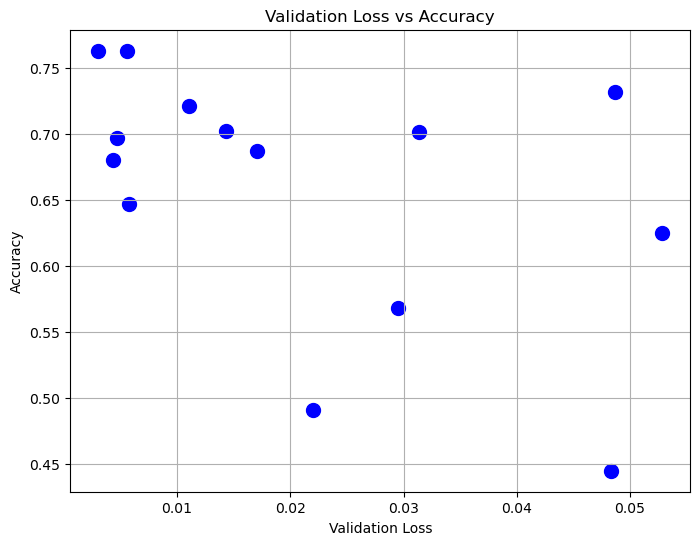

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["val_loss"], final_dict["accuracy"], c='blue', s=100)

plt.title("Validation Loss vs Accuracy")
plt.xlabel("Validation Loss")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

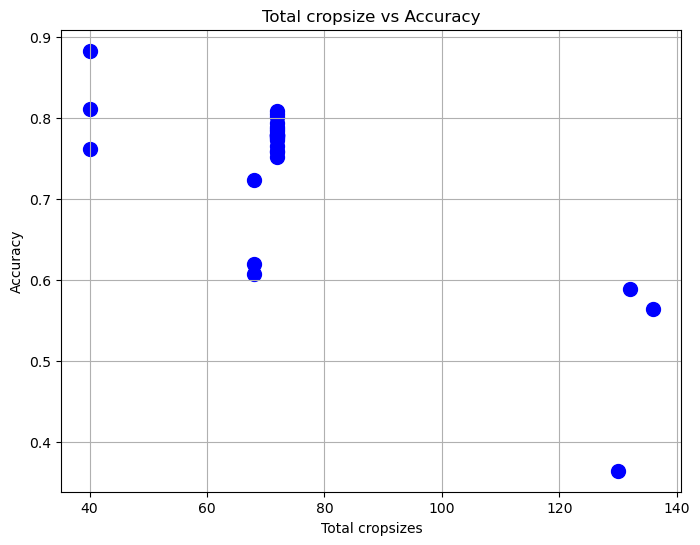

In [5]:
import numpy as np
plt.figure(figsize=(8, 6))
plt.scatter(np.array(final_dict["target_sz_z"])+np.array(final_dict["target_sz_xy"]), final_dict["accuracy"], c='blue', s=100)

plt.title("Total cropsize vs Accuracy")
plt.xlabel("Total cropsizes")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

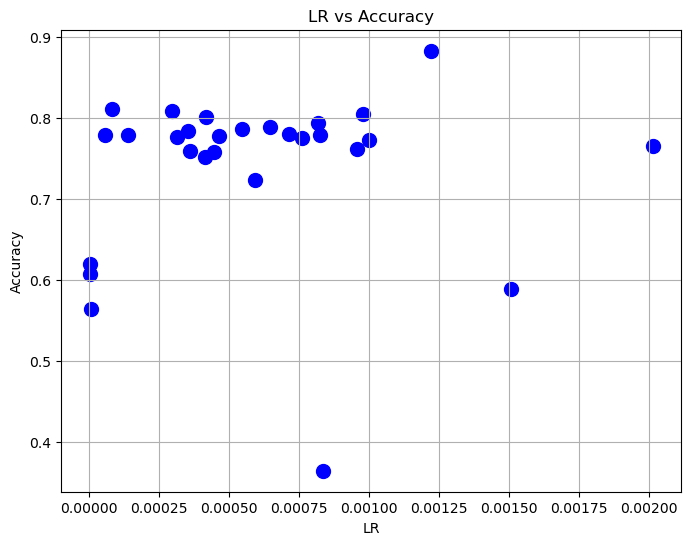

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(final_dict["lr"], final_dict["accuracy"], c='blue', s=100)

plt.title("LR vs Accuracy")
plt.xlabel("LR")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

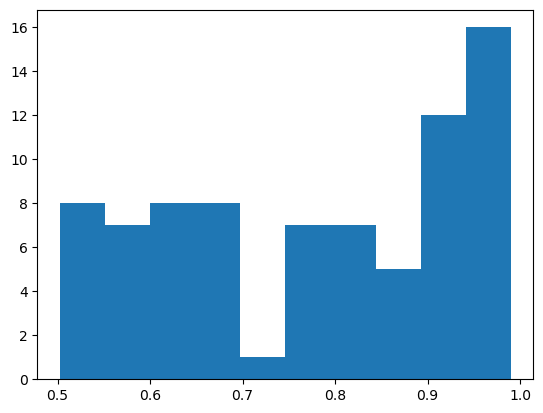

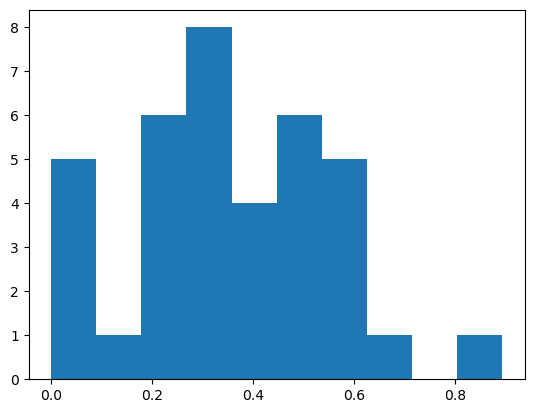

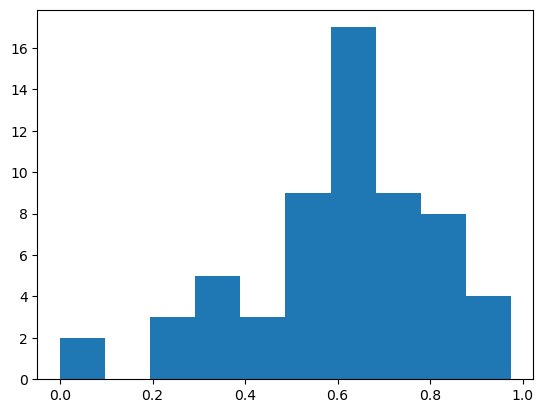

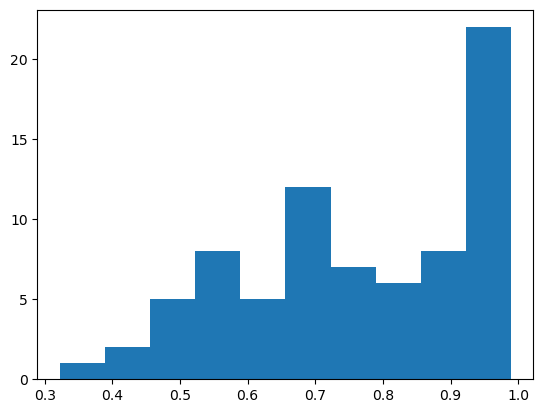

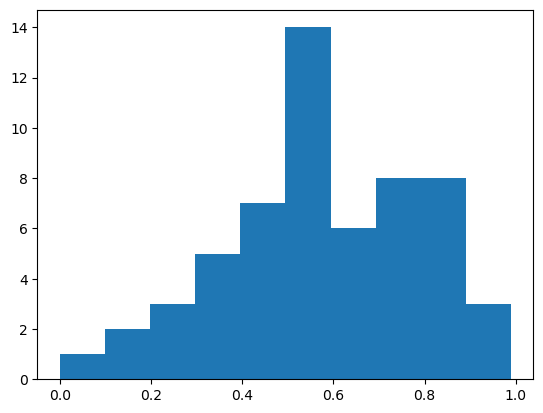

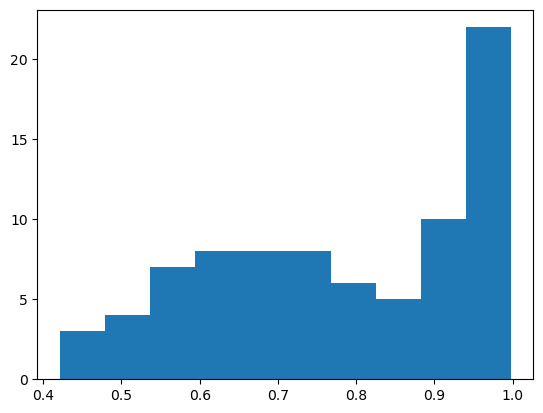

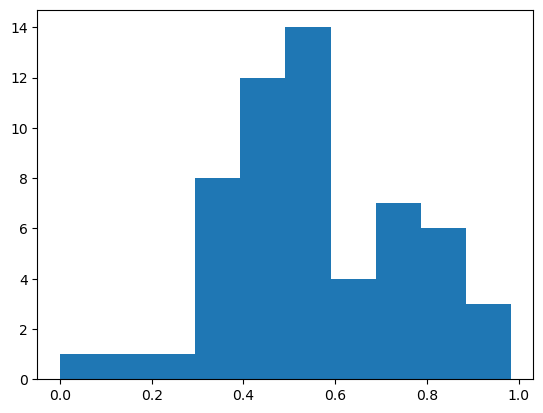

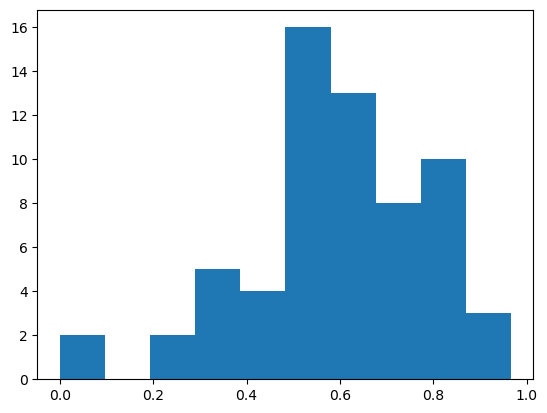

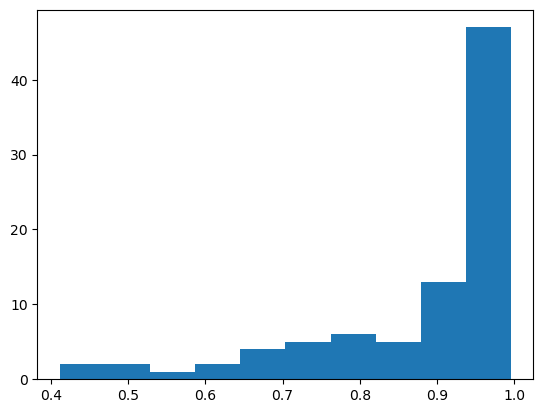

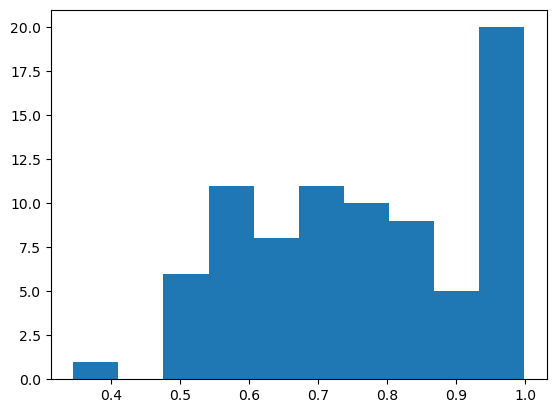

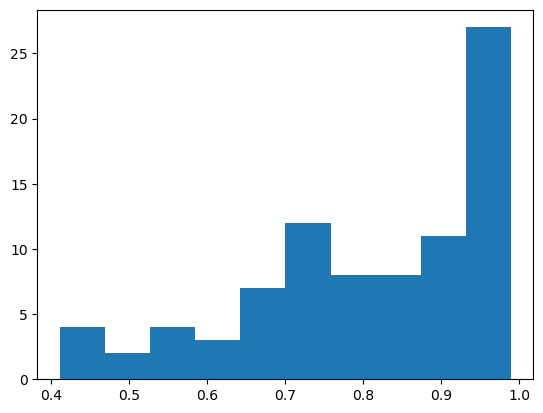

AttributeError: 'NoneType' object has no attribute 'tolist'

In [7]:
for i in range(len(final_dict["accuracy"])):
    plt.hist(final_dict["per_neuron_accuracy"][i].tolist())
    plt.show()

In [ ]:
for i in range(len(final_dict["accuracy"])):
    plt.hist(final_dict["per_timepoint_accuracy"][i].tolist())
    plt.show()

In [8]:
print(final_dict["accuracy"])


[0.7757956699590941, 0.3650363130996145, 0.6198531375166889, 0.7617396194582435, 0.5895686152365042, 0.7831776065161686, 0.5642102920104061, 0.6069922476705134, 0.8826041232253268, 0.7657147329596039, 0.8106293963495932, None, 0.7786220080760002, None, 0.7588742046010768, 0.7229120791809494, 0.7786151767848618, 0.7580793911211642, 0.8082428355191645, 0.7513813254751261, 0.8010889147680333, 0.7780382733053952, 0.7855652138674447, 0.773200158227848, 0.7930053405170376, 0.8042723974654264, 0.7783531746031747, 0.7805757891085674, 0.7744962502840693, 0.7889592708303477]


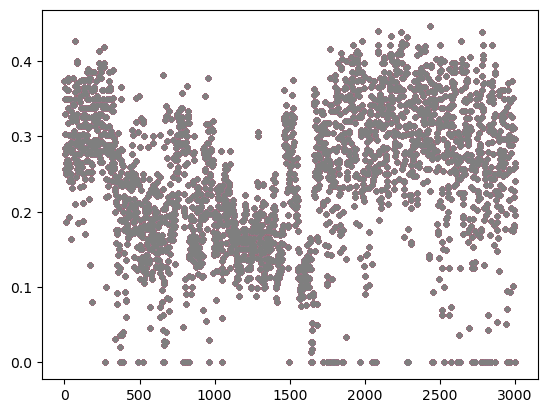

In [12]:
for i in range(len(final_dict["accuracy"])):
    plt.scatter(range(len(final_dict["per_timepoint_accuracy"][8])),final_dict["per_timepoint_accuracy"][8], s=10)

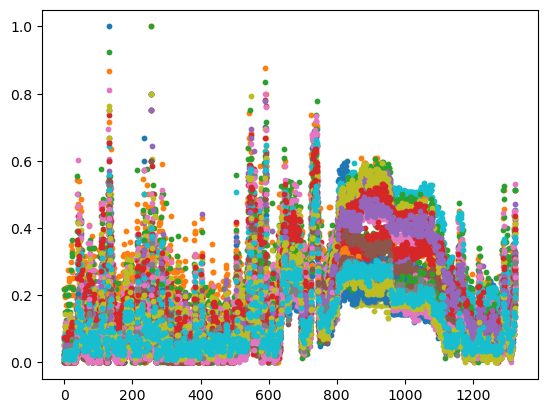

In [11]:
for i in range(len(final_dict["accuracy"])):
    plt.scatter(range(len(final_dict["per_timepoint_accuracy"][i])),final_dict["misses_per_timepoint_norm"][i], s=10)

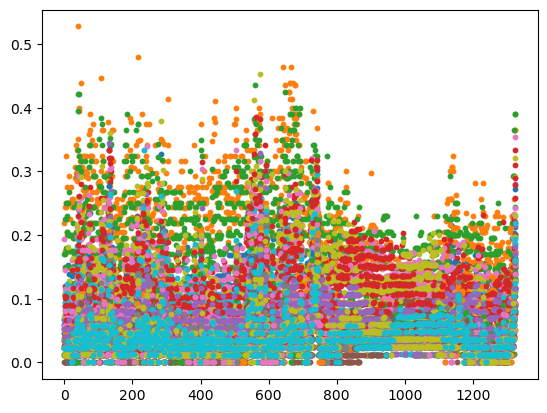

In [13]:
for i in range(len(final_dict["accuracy"])):
    plt.scatter(range(len(final_dict["per_timepoint_accuracy"][i])),final_dict["mismatches_per_timepoint_norm"][i], s=10)